# Importing the necessary libraries

In [1]:
import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

First, we read the data we produced earlier

In [2]:
Processed_Data2 = pd.read_csv('Processed_data2.csv')

#### Define Foursquare Credentials and Version

In [3]:
CLIENT_ID = 'PRFN0JQ0NG00SOQ522DCVJOUURADAZQ3CH2C1DA5K4ERRJMZ' # your Foursquare ID
CLIENT_SECRET = 'WYMELWNWQLVOUZXSLXOSTHEUEKTXNCU1FIEWF23T22PNN01H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PRFN0JQ0NG00SOQ522DCVJOUURADAZQ3CH2C1DA5K4ERRJMZ
CLIENT_SECRET:WYMELWNWQLVOUZXSLXOSTHEUEKTXNCU1FIEWF23T22PNN01H


Now let's take another look at our data 

In [4]:
Processed_Data2.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


We do not need the Postcode column anymore for this stage

In [5]:
Processed_Data2.drop(columns = 'Postcode',inplace=True)
print(print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Processed_Data2['Borough'].unique()),
        Processed_Data2.shape[0])))
Processed_Data2.head()

The dataframe has 11 boroughs and 103 neighborhoods.
None


,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


#### Create a map of Toronto with neighborhoods superimposed on top.

In [39]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[Processed_Data2.Latitude.mean(),
                                   Processed_Data2.Longitude.mean()], zoom_start=10)

# add markers to map
iterator = zip(Processed_Data2['Latitude'], Processed_Data2['Longitude'],
                Processed_Data2['Borough'], Processed_Data2['Neighborhood'])
for lat, lng, borough, neighborhood in iterator:
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        while True:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                continue
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [46]:
toronto_venues = getNearbyVenues(names=Processed_Data2['Neighborhood'],
                                 latitudes=Processed_Data2['Latitude'],
                                 longitudes=Processed_Data2['Longitude']
                                )


Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [47]:
toronto_venues.to_csv('toronto_venues.csv', index=False)
toronto_venues = pd.read_csv('toronto_venues.csv')

In [48]:
print(toronto_venues.shape)
toronto_venues.head()

(2233, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check how many venues were returned for each neighborhood

In [50]:
#venue_counts = toronto_venues.groupby('Neighborhood').Venue.count()
toronto_venues.groupby('Neighborhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",10,10,10,10,10,10
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,56,56,56,56,56,56


it looks like we have a lot of neighborhoods that have less than 100 venues.

So let's look at the distribution

In [51]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


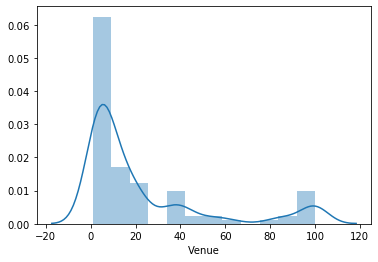

In [11]:
#sns.distplot(venue_counts);

Let's look at how many neighboorhoods have more than 75% 

In [12]:
#print(f"""The're is only {len(venue_counts[venue_counts>=75.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
#The number of these neighbourhoods is {len(venue_counts[venue_counts>=75.0])}""")

The're is only 11.11111111111111% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 11


Let's look at how many neighboorhoods have more than 25% 

In [13]:
#print(f"""The're is only {len(venue_counts[venue_counts>=25.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
#The number of these neighbourhoods is {len(venue_counts[venue_counts>=25.0])}""")

The're is only 24.242424242424242% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 24


Okay Now I will just use the Neighbourhoods with more than 25 venues 

In [52]:
#nbrhoods_used = venue_counts[venue_counts>=25.0].index 
#toronto_venues_filtered = toronto_venues[toronto_venues.Neighborhood.isin(nbrhoods_used)]
#print(toronto_venues_filtered.shape)
#toronto_venues_filtered.head()

(1618, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
95,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store
96,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,SilverCity Fairview Mall Cinemas,43.778681,-79.344085,Movie Theater
97,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Hero Certified Burgers,43.777295,-79.344584,Burger Joint
98,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery
99,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,CF Fairview Mall,43.777994,-79.343665,Shopping Mall


## 3. Analyze Each Neighborhood

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_filtered[['Venue Category']],
                                prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_filtered['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + [_ for _ in toronto_onehot.columns if _ !='Neighborhood']
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
95,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
96,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [54]:
toronto_onehot.shape

(1618, 217)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [55]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.020000,0.0,0.0,0.010000,0.000000,0.03,0.000000,0.000000,0.020000,0.000000,0.040000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010000,0.0,0.01,0.010000,0.000000,0.000000,0.01,0.030000,0.010000,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.080000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.0,0.02,0.0,0.000000,0.0,0.01,0.0,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.000000,0.02,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.000000,0.000000,0.0,0.010000,0.000000,0.0,0.0,0.000000,0.010000,0.010000

#### Let's confirm the new size

In [56]:
toronto_grouped.shape

(24, 217)

#### Let's print each neighborhood along with the top 5 most common venues

In [57]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
          venue  freq
0   Coffee Shop  0.08
1          Café  0.05
2           Bar  0.04
3    Steakhouse  0.04
4  Burger Joint  0.03


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2  Farmers Market  0.04
3            Café  0.04
4      Steakhouse  0.04


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.07
1          Pub  0.05
2       Bakery  0.05
3   Restaurant  0.05
4  Pizza Place  0.05


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.16
1      Sandwich Place  0.05
2                Café  0.05
3  Italian Restaurant  0.05
4      Ice Cream Shop  0.04


----Chinatown, Grange Park, Kensington Market----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.06
1          Vietnamese Restaurant  0.06
2                           Café  0.06
3                    Coffee Shop  0.04
4                            Bar  0.04


----Church and Welle

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Restaurant,Burger Joint,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Gym
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Farmers Market,Cheese Shop,Steakhouse,Beer Bar,Café,Bakery,Hotel
2,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Italian Restaurant,Café,Pizza Place,Bakery,Market,Pub,Snack Place,Japanese Restaurant
3,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Ice Cream Shop,Bakery,Bubble Tea Shop,Bar,Chinese Restaurant
4,"Chinatown, Grange Park, Kensington Market",Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Grocery Store


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [115]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [ ]:
#add cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Processed_Data2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

In [142]:
#removing the nan rows
toronto_merged=toronto_merged.dropna()
#converting the cluster label type to int
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
#reseting the index value 
toronto_merged.reset_index(inplace=True, drop=True)
#exporting for future use
toronto_merged.to_csv('toronto_merged_data.csv', index=False)

In [143]:
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Bakery,Japanese Restaurant,Women's Store,Toy / Game Store,Lingerie Store,Boutique
1,North York,Willowdale South,43.770120,-79.408493,1,Coffee Shop,Sushi Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Pizza Place,Café,Bubble Tea Shop,Plaza,Electronics Store
2,East York,Leaside,43.709060,-79.363452,1,Coffee Shop,Sporting Goods Shop,Sandwich Place,Burger Joint,Furniture / Home Store,Gym,Clothing Store,Bike Shop,Electronics Store,Sports Bar
3,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Yoga Studio,Pizza Place,Brewery,Bubble Tea Shop
4,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,American Restaurant,Gastropub,Italian Restaurant,Convenience Store,Seafood Restaurant,Sandwich Place,Cheese Shop


Finally, let's visualize the resulting clusters

In [144]:
# create map
map_clusters = folium.Map(location=[Processed_Data2.Latitude.mean(),
                                   Processed_Data2.Longitude.mean()], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## EXAMINING THE CLUSTERS

#### Cluster 1 - Cafeterias and restaurant, etc...

In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,0,Sandwich Place,Dessert Shop,Pizza Place,Gym,Café,Italian Restaurant,Sushi Restaurant,Coffee Shop,Seafood Restaurant,Farmers Market
6,Downtown Toronto,0,Coffee Shop,Restaurant,Italian Restaurant,Café,Pizza Place,Bakery,Market,Pub,Snack Place,Japanese Restaurant
17,Downtown Toronto,0,Café,Bookstore,Italian Restaurant,Japanese Restaurant,Sandwich Place,Restaurant,Bar,Bakery,Comfort Food Restaurant,Poutine Place
18,Downtown Toronto,0,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Grocery Store
22,West Toronto,0,Café,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bookstore,Pizza Place,Falafel Restaurant,French Restaurant,Indie Movie Theater,Grocery Store


#### Cluster 2 - Coffee shop and Good Shops, Stores , etc...

In [138]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Coffee Shop,Sushi Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Pizza Place,Café,Bubble Tea Shop,Plaza,Electronics Store
2,East York,1,Coffee Shop,Sporting Goods Shop,Sandwich Place,Burger Joint,Furniture / Home Store,Gym,Clothing Store,Bike Shop,Electronics Store,Sports Bar
4,East Toronto,1,Café,Coffee Shop,Bakery,American Restaurant,Gastropub,Italian Restaurant,Convenience Store,Seafood Restaurant,Sandwich Place,Cheese Shop
7,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Smoke Shop,Hotel
8,Downtown Toronto,1,Coffee Shop,Park,Pub,Bakery,Mexican Restaurant,Café,Breakfast Spot,Spa,Ice Cream Shop,French Restaurant
9,Downtown Toronto,1,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Burger Joint,Diner,Bakery,Bookstore,Pizza Place
10,Downtown Toronto,1,Café,Coffee Shop,Restaurant,Hotel,Breakfast Spot,Beer Bar,Clothing Store,Cosmetics Shop,Cocktail Bar,Italian Restaurant
11,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Seafood Restaurant,Farmers Market,Cheese Shop,Steakhouse,Beer Bar,Café,Bakery,Hotel
12,Downtown Toronto,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Ice Cream Shop,Bakery,Bubble Tea Shop,Bar,Chinese Restaurant
13,Downtown Toronto,1,Coffee Shop,Café,Steakhouse,Bar,Restaurant,Burger Joint,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Gym


#### Cluster 3 - Clothing store, etc...

In [139]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Food Court,Bakery,Japanese Restaurant,Women's Store,Toy / Game Store,Lingerie Store,Boutique


#### Cluster 4 - Coffee shop and gym, etc...

In [140]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Queen's Park,3,Coffee Shop,Gym,Park,Burger Joint,Burrito Place,Café,Sandwich Place,Chinese Restaurant,Portuguese Restaurant,College Auditorium
24,Downtown Toronto,3,Coffee Shop,Gym,Park,Burger Joint,Burrito Place,Café,Sandwich Place,Chinese Restaurant,Portuguese Restaurant,College Auditorium


#### Cluster 1 - Greek restaurant and coffee shop, etc...

In [141]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Toronto,4,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Yoga Studio,Pizza Place,Brewery,Bubble Tea Shop


In [146]:
# IT seems more number of coffee shops are available